## Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import open_data

data = open_data.open_without_normalization()

import rpy2.rinterface
%load_ext rpy2.ipython

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%%R
library(MASS)
library(rgl)
library(DepthProc)
library(hexbin)
library(aplpack)
library(robustbase)

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: Rcpp

R[write to console]: Loading required package: rrcov

R[write to console]: Loading required package: robustbase

R[write to console]: Scalable Robust Estimators with High Breakdown Point (version 1.7-2)


R[write to console]: Loading required package: np

R[write to console]: Nonparametric Kernel Methods for Mixed Datatypes (version 0.60-16)
[vignette("np_faq",package="np") provides answers to frequently asked questions]
[vignette("np",package="np") an overview]
[vignette("entropy_np",package="np") an overview of entropy-based methods]

R[write to console]: 
Attaching package: ‘DepthProc’


R[write to console]: The following object is masked from ‘package:base’:

    as.matrix




## Analisi

In [4]:
df = data['df']
df = df[['TARGET','EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE']]
df

,TARGET,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE
0,0,0.555912,7.030556,2.263889,0.010032
1,0,0.746644,11.088889,4.647222,0.019689
2,0,0.683513,6.741667,7.808333,0.010966
3,0,0.706428,3.497222,0.663889,0.046220
4,0,0.113375,5.000000,0.822222,0.015221
...,...,...,...,...,...
19462,0,0.443514,6.186111,0.300000,0.018209
19463,0,0.658507,8.352778,2.797222,0.004960
19464,1,0.318262,13.163889,0.808333,0.002042
19465,0,0.706800,13.825000,0.094444,0.046220


In [5]:
to_compute_median = df.sample(frac=2/3)

In [6]:
to_compute_ranks = df.loc[~df.index.isin(to_compute_median.index.to_list())].copy()

In [7]:
to_compute_median = to_compute_median.sort_index()

In [8]:
to_compute_median_0 = to_compute_median[to_compute_median['TARGET']=='0'].copy()
to_compute_median_1 = to_compute_median[to_compute_median['TARGET']=='1'].copy()
to_compute_median_0.drop(columns=['TARGET'], inplace=True)
to_compute_median_1.drop(columns=['TARGET'], inplace=True)
to_compute_median.drop(columns=['TARGET'], inplace=True)

In [9]:
%%R -i to_compute_median_0 -i to_compute_median_1

head(to_compute_median_0)
head(to_compute_median_1)

    EXT_SOURCE_2 DAYS_ID_PUBLISH DAYS_LAST_PHONE_CHANGE
24    0.37211026        2.200000              1.1916667
30    0.52323039        5.061111              0.1777778
48    0.33598123       11.005556              1.2305556
93    0.58943008        4.911111              1.3861111
120   0.01789932       12.575000              0.3277778
131   0.27324573        2.022222              1.8972222
    REGION_POPULATION_RELATIVE
24                    0.024610
30                    0.018801
48                    0.026392
93                    0.024610
120                   0.018801
131                   0.008625


In [10]:
%%R -i to_compute_median -o tukey_depth_0 -o tukey_depth_1 -o tukey_depth

tukey_depth_0 = depth(u=to_compute_median_0, method = 'Tukey')
tukey_depth_1 = depth(u=to_compute_median_1, method = 'Tukey')
tukey_depth = depth(u=to_compute_median, method = 'Tukey')


In [11]:
to_compute_median_0['DEPTH'] = tukey_depth_0
to_compute_median_1['DEPTH'] = tukey_depth_1
to_compute_median['DEPTH'] = tukey_depth

In [12]:
tukey_median_0 = to_compute_median_0.loc[to_compute_median_0[['DEPTH']].idxmax()]
tukey_median_1 = to_compute_median_1.loc[to_compute_median_1[['DEPTH']].idxmax()]
tukey_median = to_compute_median.loc[to_compute_median[['DEPTH']].idxmax()]

In [13]:
medians = {'0': tukey_median_0, '1': tukey_median_1}

In [14]:
medians

{'0':        EXT_SOURCE_2  DAYS_ID_PUBLISH  DAYS_LAST_PHONE_CHANGE  \
 17489      0.520546         8.144444                1.952778   
 
        REGION_POPULATION_RELATIVE    DEPTH  
 17489                    0.010276  0.41653  ,
 '1':      EXT_SOURCE_2  DAYS_ID_PUBLISH  DAYS_LAST_PHONE_CHANGE  \
 467      0.369544         5.466667                1.305556   
 
      REGION_POPULATION_RELATIVE    DEPTH  
 467                    0.018209  0.41029  }

distance_from_median_0 = sp.spatial.distance.cdist(to_compute_ranks.values[:,1:5].astype(np.float32), np.array([medians['0'].iloc[0].values[1:5].astype(np.float32)]))
to_compute_ranks['DIST_FROM_MEDIAN_0'] = distance_from_median_0
distance_from_median_1 = sp.spatial.distance.cdist(to_compute_ranks.values[:,1:5].astype(np.float32), np.array([medians['1'].iloc[0].values[1:5].astype(np.float32)]))
to_compute_ranks['DIST_FROM_MEDIAN_1'] = distance_from_median_1

In [15]:
CovMat = np.cov(to_compute_ranks.values[:,1:5].astype(np.float32) - tukey_median.values[0,0:4].astype(np.float32), rowvar=False)

In [16]:
VI = np.linalg.inv(CovMat)

In [17]:
distance_from_median_0 = sp.spatial.distance.cdist(to_compute_ranks.values[:,1:5].astype(np.float32), 
                                                   np.array([medians['0'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)

distance_from_median_1 = sp.spatial.distance.cdist(to_compute_ranks.values[:,1:5].astype(np.float32), 
                                                   np.array([medians['1'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)


to_compute_ranks['DIST_FROM_MEDIAN_0'] = distance_from_median_0
to_compute_ranks['DIST_FROM_MEDIAN_1'] = distance_from_median_1

In [18]:
to_compute_ranks

,TARGET,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DIST_FROM_MEDIAN_0,DIST_FROM_MEDIAN_1
2,0,0.683513,6.741667,7.808333,0.010966,2.985543,3.486499
3,0,0.706428,3.497222,0.663889,0.046220,2.809199,2.533992
5,0,0.502779,8.375000,1.663889,0.030755,1.469563,1.204402
8,0,0.450850,7.155556,0.000000,0.014520,1.034952,1.023339
12,0,0.304506,6.225000,2.888889,0.020246,1.715142,0.941694
...,...,...,...,...,...,...,...
19453,0,0.659180,11.122222,5.322222,0.019689,1.846361,2.522077
19461,0,0.508404,11.747222,4.491667,0.031329,2.113368,2.191230
19464,1,0.318262,13.163889,0.808333,0.002042,1.824173,2.175614
19465,0,0.706800,13.825000,0.094444,0.046220,3.063652,3.215497


In [19]:
'DIST_FROM_MEDIAN_' + '0'

'DIST_FROM_MEDIAN_0'

In [20]:
for row in to_compute_ranks.index:
    aux_target = to_compute_ranks.loc[row].values[0]
    col_num = 'DIST_FROM_MEDIAN_' + aux_target
    col_den = 'DIST_FROM_MEDIAN_' + str(int(not int(aux_target)))
    to_compute_ranks.loc[row, 'DISSIMILARITY'] = to_compute_ranks.loc[row, col_num]/to_compute_ranks.loc[row, col_den]


for row in to_compute_ranks.index:
    aux_target = to_compute_ranks.loc[row].values[0]
    aux_val = to_compute_ranks.loc[row].values[1:5].astype(np.float32)
    aux_val_his_median = medians[aux_target].iloc[0].values[1:5].astype(np.float32)
    aux_val_other_median = medians[str(int(not int(aux_target)))].iloc[0].values[1:].astype(np.float32)
    
    to_compute_ranks.loc[row, 'DISSIMILARITY'] = ( sp.spatial.distance.cdist(np.array([aux_val]), np.array([aux_val_his_median]))[0,0] )/( sp.spatial.distance.cdist(np.array([aux_val]), np.array([aux_val_other_median]))[0,0] )


In [21]:
to_compute_ranks

,TARGET,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DIST_FROM_MEDIAN_0,DIST_FROM_MEDIAN_1,DISSIMILARITY
2,0,0.683513,6.741667,7.808333,0.010966,2.985543,3.486499,0.856315
3,0,0.706428,3.497222,0.663889,0.046220,2.809199,2.533992,1.108606
5,0,0.502779,8.375000,1.663889,0.030755,1.469563,1.204402,1.220159
8,0,0.450850,7.155556,0.000000,0.014520,1.034952,1.023339,1.011349
12,0,0.304506,6.225000,2.888889,0.020246,1.715142,0.941694,1.821336
...,...,...,...,...,...,...,...,...
19453,0,0.659180,11.122222,5.322222,0.019689,1.846361,2.522077,0.732079
19461,0,0.508404,11.747222,4.491667,0.031329,2.113368,2.191230,0.964467
19464,1,0.318262,13.163889,0.808333,0.002042,1.824173,2.175614,1.192658
19465,0,0.706800,13.825000,0.094444,0.046220,3.063652,3.215497,0.952777


In [22]:
to_compute_ranks_0 = to_compute_ranks[to_compute_ranks['TARGET'] == '0'].copy()
to_compute_ranks_1 = to_compute_ranks[to_compute_ranks['TARGET'] == '1'].copy()

In [23]:
to_compute_ranks_0 = to_compute_ranks_0.sort_values(by='DISSIMILARITY')
to_compute_ranks_1 = to_compute_ranks_1.sort_values(by='DISSIMILARITY')

In [24]:
to_compute_ranks_0['RANK'] = np.arange(0,to_compute_ranks_0.shape[0])
to_compute_ranks_1['RANK'] = np.arange(0,to_compute_ranks_1.shape[0])

In [25]:
to_compute_ranks_0.set_index('RANK', inplace=True)
to_compute_ranks_1.set_index('RANK', inplace=True)

In [26]:
to_compute_ranks_0.drop(columns=['TARGET'], inplace=True)
to_compute_ranks_1.drop(columns=['TARGET'], inplace=True)

In [27]:
to_compute_ranks_0

,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DIST_FROM_MEDIAN_0,DIST_FROM_MEDIAN_1,DISSIMILARITY
RANK,,,,,,,
0,0.515113,8.083333,1.750000,0.010500,0.100880,1.187471,0.084953
1,0.546717,8.294444,2.102778,0.009657,0.169208,1.382942,0.122353
2,0.535423,7.716667,2.355556,0.006671,0.361293,1.444205,0.250167
3,0.584319,7.855556,2.350000,0.008575,0.441204,1.575708,0.280003
4,0.534536,7.372222,1.352778,0.009657,0.354556,1.266065,0.280045
...,...,...,...,...,...,...,...
6142,0.373435,5.486111,1.602778,0.022625,1.415756,0.343533,4.121162
6143,0.361163,6.397222,1.152778,0.020246,1.294606,0.293391,4.412569
6144,0.338640,4.708333,0.972222,0.019101,1.481893,0.275498,5.378959


In [28]:
to_compute_ranks_1

,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DIST_FROM_MEDIAN_0,DIST_FROM_MEDIAN_1,DISSIMILARITY
RANK,,,,,,,
0,0.379306,5.777778,1.375000,0.015221,1.041273,0.236149,0.226789
1,0.349795,4.452778,1.061111,0.015221,1.332463,0.326092,0.244728
2,0.356263,3.919444,0.386111,0.018209,1.540917,0.532771,0.345749
3,0.391040,3.019444,1.247222,0.020246,1.567036,0.606146,0.386811
4,0.307362,3.522222,1.625000,0.025164,1.989726,0.826301,0.415284
...,...,...,...,...,...,...,...
337,0.587540,7.597222,3.294444,0.006008,0.830832,1.813455,2.182697
338,0.677977,8.822222,2.302778,0.006008,0.992547,2.168768,2.185055
339,0.579350,11.036111,1.941667,0.006207,0.812185,1.965371,2.419855


In [29]:
alpha = 1 - 0.50
dissimilarity_bounds = {
    '0': to_compute_ranks_0.loc[to_compute_ranks_0.index == (to_compute_ranks_0.shape[0] - np.ceil(alpha*to_compute_ranks_0.shape[0]) - 1), 'DISSIMILARITY'].values[0], 
    '1': to_compute_ranks_1.loc[to_compute_ranks_1.index == (to_compute_ranks_1.shape[0] - np.ceil(alpha*to_compute_ranks_1.shape[0]) - 1), 'DISSIMILARITY'].values[0]
}

In [30]:
dissimilarity_bounds

{'0': 0.9296996979382876, '1': 0.9016189410206487}

In [31]:
1/dissimilarity_bounds['1']

1.1091160073323019

In [32]:
coordinates = np.meshgrid(np.linspace(df.EXT_SOURCE_2.min(),df.EXT_SOURCE_2.max(),30), np.linspace(df.DAYS_ID_PUBLISH.min(),df.DAYS_ID_PUBLISH.max(),30), 
                          np.linspace(df.DAYS_LAST_PHONE_CHANGE.min(),df.DAYS_LAST_PHONE_CHANGE.max(),30), 
                          np.linspace(df.REGION_POPULATION_RELATIVE.min(), df.REGION_POPULATION_RELATIVE.max(),30))

df_coor = pd.DataFrame()
df_coor['EXT_SOURCE_2'] = coordinates[0].flatten()
df_coor['DAYS_ID_PUBLISH'] = coordinates[1].flatten()
df_coor['DAYS_LAST_PHONE_CHANGE'] = coordinates[2].flatten()
df_coor['REGION_POPULATION_RELATIVE'] = coordinates[3].flatten()

In [33]:
df_coor

,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE
0,0.000001,0.002778,0.00,0.000533
1,0.000001,0.002778,0.00,0.003015
2,0.000001,0.002778,0.00,0.005497
3,0.000001,0.002778,0.00,0.007979
4,0.000001,0.002778,0.00,0.010461
...,...,...,...,...
809995,0.855000,17.402778,11.05,0.062580
809996,0.855000,17.402778,11.05,0.065062
809997,0.855000,17.402778,11.05,0.067544
809998,0.855000,17.402778,11.05,0.070026


In [34]:
distance_from_median_0 = sp.spatial.distance.cdist(df_coor.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['0'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)

distance_from_median_1 = sp.spatial.distance.cdist(df_coor.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['1'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)


df_coor['DISSIMILARITY_FROM_0'] = distance_from_median_0/distance_from_median_1
df_coor['predict_0'] = (df_coor['DISSIMILARITY_FROM_0'] <= dissimilarity_bounds['0'])
df_coor['predict_1'] = (df_coor['DISSIMILARITY_FROM_0'] >= (1/dissimilarity_bounds['1']))

In [35]:
df_coor

,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DISSIMILARITY_FROM_0,predict_0,predict_1
0,0.000001,0.002778,0.00,0.000533,1.345781,False,True
1,0.000001,0.002778,0.00,0.003015,1.375535,False,True
2,0.000001,0.002778,0.00,0.005497,1.403580,False,True
3,0.000001,0.002778,0.00,0.007979,1.428973,False,True
4,0.000001,0.002778,0.00,0.010461,1.450834,False,True
...,...,...,...,...,...,...,...
809995,0.855000,17.402778,11.05,0.062580,0.964936,False,False
809996,0.855000,17.402778,11.05,0.065062,0.969239,False,False
809997,0.855000,17.402778,11.05,0.067544,0.973348,False,False
809998,0.855000,17.402778,11.05,0.070026,0.977262,False,False


In [36]:
df_coor_to_plot = df_coor[(df_coor['REGION_POPULATION_RELATIVE'] == df_coor['REGION_POPULATION_RELATIVE'].unique()[10]) &
                          (df_coor['DAYS_LAST_PHONE_CHANGE'] == df_coor['DAYS_LAST_PHONE_CHANGE'].unique()[10])]

In [37]:
df_coor_to_plot

,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,DISSIMILARITY_FROM_0,predict_0,predict_1
310,0.000001,0.002778,3.810345,0.025352,1.331443,False,True
1210,0.029484,0.002778,3.810345,0.025352,1.343643,False,True
2110,0.058967,0.002778,3.810345,0.025352,1.355780,False,True
3010,0.088449,0.002778,3.810345,0.025352,1.367583,False,True
3910,0.117932,0.002778,3.810345,0.025352,1.378693,False,True
...,...,...,...,...,...,...,...
805810,0.737069,17.402778,3.810345,0.025352,0.768836,True,False
806710,0.766552,17.402778,3.810345,0.025352,0.765007,True,False
807610,0.796034,17.402778,3.810345,0.025352,0.762777,True,False
808510,0.825517,17.402778,3.810345,0.025352,0.761959,True,False


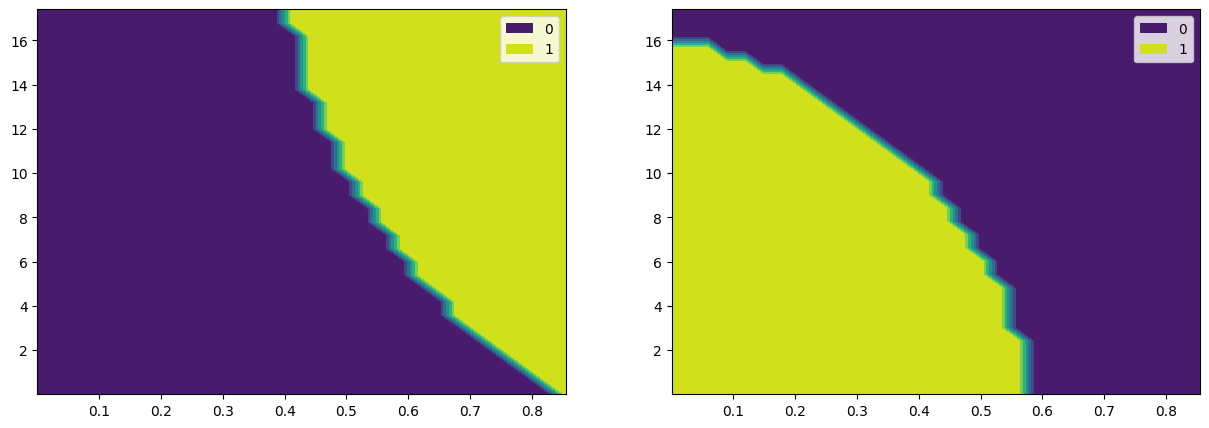

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
            np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
            np.reshape(df_coor_to_plot['predict_0'].to_numpy().astype(np.float32), (30,30)) )

#proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
#         for pc in cs.collections]

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0], cs.collections[-1]]]
plt.legend(proxy, ['0','1'])

plt.subplot(1,2,2)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
            np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
            np.reshape(df_coor_to_plot['predict_1'].to_numpy().astype(np.float32), (30,30)) )

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0], cs.collections[-1]]]
plt.legend(proxy, ['0','1'])


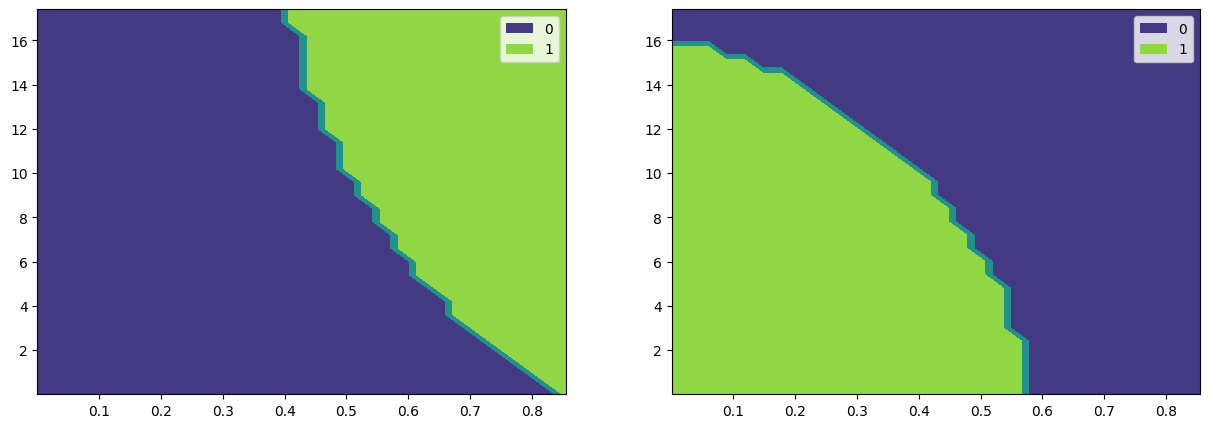

In [39]:
alpha = 1 - 0.50
index_REGION = 10
index_PHONE = 10

dissimilarity_bounds = {
    '0': to_compute_ranks_0.loc[to_compute_ranks_0.index == (to_compute_ranks_0.shape[0] - np.ceil(alpha*to_compute_ranks_0.shape[0]) - 1), 'DISSIMILARITY'].values[0], 
    '1': to_compute_ranks_1.loc[to_compute_ranks_1.index == (to_compute_ranks_1.shape[0] - np.ceil(alpha*to_compute_ranks_1.shape[0]) - 1), 'DISSIMILARITY'].values[0]
}
coordinates = np.meshgrid(np.linspace(df.EXT_SOURCE_2.min(),df.EXT_SOURCE_2.max(),30), np.linspace(df.DAYS_ID_PUBLISH.min(),df.DAYS_ID_PUBLISH.max(),30), 
                          np.linspace(df.DAYS_LAST_PHONE_CHANGE.min(),df.DAYS_LAST_PHONE_CHANGE.max(),30), 
                          np.linspace(df.REGION_POPULATION_RELATIVE.min(), df.REGION_POPULATION_RELATIVE.max(),30))

df_coor = pd.DataFrame()
df_coor['EXT_SOURCE_2'] = coordinates[0].flatten()
df_coor['DAYS_ID_PUBLISH'] = coordinates[1].flatten()
df_coor['DAYS_LAST_PHONE_CHANGE'] = coordinates[2].flatten()
df_coor['REGION_POPULATION_RELATIVE'] = coordinates[3].flatten()

distance_from_median_0 = sp.spatial.distance.cdist(df_coor.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['0'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)

distance_from_median_1 = sp.spatial.distance.cdist(df_coor.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['1'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)


df_coor['DISSIMILARITY_FROM_0'] = distance_from_median_0/distance_from_median_1
df_coor['predict_0'] = (df_coor['DISSIMILARITY_FROM_0'] <= dissimilarity_bounds['0'])
df_coor['predict_1'] = (df_coor['DISSIMILARITY_FROM_0'] >= (1/dissimilarity_bounds['1']))

df_coor_to_plot = df_coor[(df_coor['REGION_POPULATION_RELATIVE'] == df_coor['REGION_POPULATION_RELATIVE'].unique()[index_REGION]) &
                          (df_coor['DAYS_LAST_PHONE_CHANGE'] == df_coor['DAYS_LAST_PHONE_CHANGE'].unique()[index_PHONE])]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['predict_0'].to_numpy().astype(np.float32), (30,30)) , 2)

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0], cs.collections[-1]]]

if (len(df_coor_to_plot['predict_0'].unique()) == 2):
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0], cs.collections[-1]]]
    plt.legend(proxy, ['0','1'])
elif (df_coor_to_plot['predict_0'].unique()[0] == True):
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0]]]
    plt.legend(proxy, ['1'])
else:
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0]]]
    plt.legend(proxy, ['0'])

plt.subplot(1,2,2)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['predict_1'].to_numpy().astype(np.float32), (30,30)) , 2)

if (len(df_coor_to_plot['predict_1'].unique()) == 2):
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0], cs.collections[-1]]]
    plt.legend(proxy, ['0','1'])
elif (df_coor_to_plot['predict_1'].unique()[0] == True):
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0]]]
    plt.legend(proxy, ['1'])
else:
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in [cs.collections[0]]]
    plt.legend(proxy, ['0'])


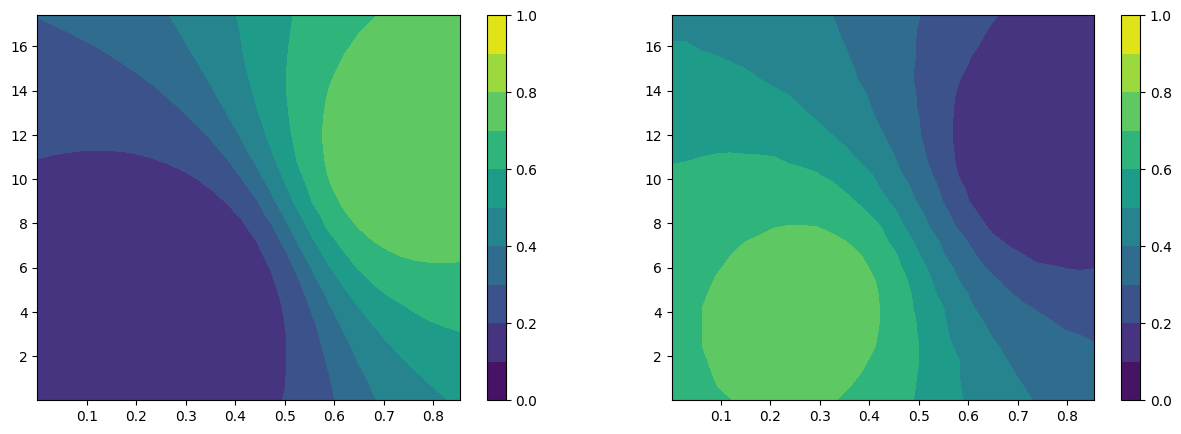

In [40]:
index_REGION = 10
index_PHONE = 10

coordinates = np.meshgrid(np.linspace(df.EXT_SOURCE_2.min(),df.EXT_SOURCE_2.max(),30), np.linspace(df.DAYS_ID_PUBLISH.min(),df.DAYS_ID_PUBLISH.max(),30), 
                          np.linspace(df.DAYS_LAST_PHONE_CHANGE.min(),df.DAYS_LAST_PHONE_CHANGE.max(),30), 
                          np.linspace(df.REGION_POPULATION_RELATIVE.min(), df.REGION_POPULATION_RELATIVE.max(),30))

df_coor = pd.DataFrame()
df_coor['EXT_SOURCE_2'] = coordinates[0].flatten()
df_coor['DAYS_ID_PUBLISH'] = coordinates[1].flatten()
df_coor['DAYS_LAST_PHONE_CHANGE'] = coordinates[2].flatten()
df_coor['REGION_POPULATION_RELATIVE'] = coordinates[3].flatten()


df_coor_to_plot = df_coor[(df_coor['REGION_POPULATION_RELATIVE'] == df_coor['REGION_POPULATION_RELATIVE'].unique()[index_REGION]) &
                          (df_coor['DAYS_LAST_PHONE_CHANGE'] == df_coor['DAYS_LAST_PHONE_CHANGE'].unique()[index_PHONE])].copy()


distance_from_median_0 = sp.spatial.distance.cdist(df_coor_to_plot.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['0'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)

distance_from_median_1 = sp.spatial.distance.cdist(df_coor_to_plot.values[:,0:4].astype(np.float32), 
                                                   np.array([medians['1'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)



df_coor_to_plot['DISSIMILARITY_FROM_0'] = distance_from_median_0/distance_from_median_1
df_coor_to_plot['p_val_0'] = [np.mean(dissimilarity <= to_compute_ranks_0['DISSIMILARITY']) for dissimilarity in df_coor_to_plot['DISSIMILARITY_FROM_0']]
df_coor_to_plot['p_val_1'] = [np.mean((1/dissimilarity) <= to_compute_ranks_1['DISSIMILARITY']) for dissimilarity in df_coor_to_plot['DISSIMILARITY_FROM_0']]


plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['p_val_0'].to_numpy().astype(np.float32), (30,30)), np.linspace(0,1,11))
plt.colorbar(cs)


plt.subplot(1,2,2)
cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                  np.reshape(df_coor_to_plot['p_val_1'].to_numpy().astype(np.float32), (30,30)), np.linspace(0,1,11))
plt.colorbar(cs)



In [41]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [42]:
@widgets.interact(index_PHONE=(0,29),index_REGION=(0,29))
def f(index_PHONE=10, index_REGION=10):
    
    coordinates = np.meshgrid(np.linspace(df.EXT_SOURCE_2.min(),df.EXT_SOURCE_2.max(),30), np.linspace(df.DAYS_ID_PUBLISH.min(),df.DAYS_ID_PUBLISH.max(),30), 
                              np.linspace(df.DAYS_LAST_PHONE_CHANGE.min(),df.DAYS_LAST_PHONE_CHANGE.max(),30), 
                              np.linspace(df.REGION_POPULATION_RELATIVE.min(), df.REGION_POPULATION_RELATIVE.max(),30))

    df_coor = pd.DataFrame()
    df_coor['EXT_SOURCE_2'] = coordinates[0].flatten()
    df_coor['DAYS_ID_PUBLISH'] = coordinates[1].flatten()
    df_coor['DAYS_LAST_PHONE_CHANGE'] = coordinates[2].flatten()
    df_coor['REGION_POPULATION_RELATIVE'] = coordinates[3].flatten()


    df_coor_to_plot = df_coor[(df_coor['REGION_POPULATION_RELATIVE'] == df_coor['REGION_POPULATION_RELATIVE'].unique()[index_REGION]) &
                              (df_coor['DAYS_LAST_PHONE_CHANGE'] == df_coor['DAYS_LAST_PHONE_CHANGE'].unique()[index_PHONE])].copy()


    distance_from_median_0 = sp.spatial.distance.cdist(df_coor_to_plot.values[:,0:4].astype(np.float32), 
                                                       np.array([medians['0'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)

    distance_from_median_1 = sp.spatial.distance.cdist(df_coor_to_plot.values[:,0:4].astype(np.float32), 
                                                       np.array([medians['1'].iloc[0].values[0:4].astype(np.float32)]), 'mahalanobis', VI=VI)



    df_coor_to_plot['DISSIMILARITY_FROM_0'] = distance_from_median_0/distance_from_median_1
    df_coor_to_plot['p_val_0'] = [np.mean(dissimilarity <= to_compute_ranks_0['DISSIMILARITY']) for dissimilarity in df_coor_to_plot['DISSIMILARITY_FROM_0']]
    df_coor_to_plot['p_val_1'] = [np.mean((1/dissimilarity) <= to_compute_ranks_1['DISSIMILARITY']) for dissimilarity in df_coor_to_plot['DISSIMILARITY_FROM_0']]


    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                      np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                      np.reshape(df_coor_to_plot['p_val_0'].to_numpy().astype(np.float32), (30,30)), np.linspace(0,1,11))
    plt.colorbar(cs)
    plt.xlabel('EXT_SOURCE_2')
    plt.ylabel('DAYS_ID_PUBLISH')
    

    plt.subplot(1,2,2)
    cs = plt.contourf(np.reshape(df_coor_to_plot['EXT_SOURCE_2'].to_numpy(), (30,30)), 
                      np.reshape(df_coor_to_plot['DAYS_ID_PUBLISH'].to_numpy(), (30,30)), 
                      np.reshape(df_coor_to_plot['p_val_1'].to_numpy().astype(np.float32), (30,30)), np.linspace(0,1,11))
    plt.colorbar(cs)
    plt.xlabel('EXT_SOURCE_2')
    plt.ylabel('DAYS_ID_PUBLISH')


interactive(children=(IntSlider(value=10, description='index_PHONE', max=29), IntSlider(value=10, description=…